# Ben, Jacob, Caleb, and Denver
## Module 2 Bank Data Project

### Training our Model

First we import the multitude of libraries necessary for our project

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy
import sklearn
import pandas.core
import altair as alt
import pickle
from sklearn import tree
from scipy.stats import entropy
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn import metrics

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Load our bank data. One for our model, and a copy for when we calculate information gain

In [ ]:
camp = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank.csv')
for_infogain_function = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank.csv') #For the info gain function 
camp

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


We need to format our data before feeding it into our machine learning model. First, we convert all of our "Yes", "No" columns into 1s and 0s. For "Unknown" values, we can convert those to a 0. Looking at the data, we found that the patterns for the "Unknown"s closely resembled the "No"s.

We also bin the ages into 4 different values. We also need to remove month, previous outcome, and default on a loan from our data, as we saw it had no impact on our eventual model. Lastly, we can one-hot encode all of our categorical features.

In [ ]:
camp['housing'] = camp['housing'].map({'yes':1,'no':0,'unknown':0})
camp['loan'] = camp['loan'].map({'yes':1,'no':0,'unknown':0})
camp['y'] = camp['y'].map({'yes':1,'no':0}) # y is our target
camp['age'] = pd.cut(camp['age'], bins=4, labels=['1', '2', '3', '4']) # 1 = '16.919-37.25', 2 = '37.25-57.5', 3 = '57.5-77.75', 4 = '77.75-98.0'
camp = camp.drop(['month', 'poutcome', 'default'], axis=1)
camp = pd.get_dummies(data=camp, columns=['job','day_of_week', 'education','contact','marital'],dtype=int)

Now we split the data into our features (what we use to train the model) and the target (what we want to predict). There are way more occurences in the y column of "no" than there are of "yes", so in order to create a more balanced graph, we randomly duplicate instances of the "yes" observations in our data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2)

In [ ]:
X = camp.loc[:, camp.columns != 'y'] # Features are all the columns minus the target
y = camp.y # Target
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Next, we need to split our data into a train and a tests set. We use 20% of our data to test.

We ended up doing some trial and error until we found that a depth of 36 was perfect for this decision tree without overfitting. We train the model, then generate predictions based on our test data.

In [ ]:
clf = DecisionTreeClassifier(max_depth = 36)

clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

### Metrics of our Model

Finally, using our predicted target, we can calculate metrics on our model. We're mainly concerned with accuracy and recall. If we predicted no, but the person we didn't call would have actually said yes, that's a significant financial loss for the bank. However, if we predicted a person would say yes and they didn't, that's not really a financial loss, just a minute or two of call time. 

Because of this, we're mainly concerned with our recall. Our accuracy is 93%, which isn't perfect, but our recall is 99%, which is amazing. That tells us that whenever our model doesn't predict correctly, it's not really a financial loss to the company.

Accuracy: 0.9341313269493844
Recall:  0.9895661724327293
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      7336
           1       0.89      0.99      0.94      7284

    accuracy                           0.93     14620
   macro avg       0.94      0.93      0.93     14620
weighted avg       0.94      0.93      0.93     14620



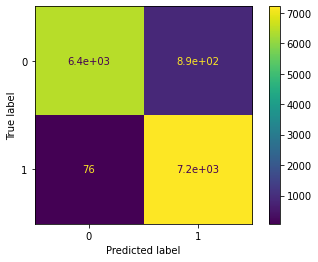

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Recall: ", metrics.recall_score(y_test, y_pred))

plot_confusion_matrix(clf, X_test, y_test)
plt.grid(False)
from sklearn.metrics import classification_report
pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(classification_report(y_test, y_pred))

Here we can see the importance of each feature (some of this is explained more in the executive summary

In [ ]:
feature_df = pd.DataFrame({'features':X.columns, 'importance':clf.feature_importances_})

alt.Chart(feature_df).mark_bar().encode(
    x = 'importance',
     y = alt.Y('features', sort='-x')
 )

alt.Chart(...)

### Save Our Model and Predict New Data

Here we save our model to be able to be used later. Now we'll use 'loaded_model' to predict the new set of customers

In [ ]:
filename = 'bank_model.sav'
pickle.dump(clf, open(filename, 'wb')) 

loaded_model = pickle.load(open(filename, 'rb'))

Let's load our new bank data

In [ ]:
camp2 = pd.read_csv('/content/bank_data_2.csv')

We need to format our data a bit before feeding it into the model. We'll use the same formatting as above

In [ ]:
camp2['housing'] = camp2['housing'].map({'yes':1,'no':0,'unknown':0})
camp2['loan'] = camp2['loan'].map({'yes':1,'no':0,'unknown':0})
camp2['age'] = pd.cut(camp2['age'], bins=4, labels=['1', '2', '3', '4']) # 1 = '16.919-37.25', 2 = '37.25-57.5', 3 = '57.5-77.75', 4 = '77.75-98.0'
camp2 = camp2.drop(['month', 'poutcome', 'default'], axis=1)
camp2 = pd.get_dummies(data=camp2, columns=['job','day_of_week', 'education','contact','marital'],dtype=int)

Now we predict and save our new bank data

In [ ]:
y_pred = loaded_model.predict(camp2)
np.savetxt("new_bank_data_predictions.csv", y_pred, delimiter=",")

### Above and Beyond Functions

Below are several functions that we developed to calculate information gain. Because these functions don't really work with our dummy columns above, we need to start with a fresh copy of the data (hence why we imported the data twice above).

In [ ]:
def calc_entropy(column):
    """
    Calculate entropy given a pandas series.
    """
    from scipy.stats import entropy
    pd_series = pd.Series(column)
    counts = pd_series.value_counts()
    entropy = entropy(counts,base=2)
    return entropy


In [ ]:
def calc_information_gain_ratio(data, split_name, target_name):
    """
    Calculate information gain given a data set, column to split on, and target
    """
    # Calculate the original entropy
    original_entropy = calc_entropy(data[target_name])
    feature_entropy = calc_entropy(data[split_name])
    #Find the unique values in the column
    values = data[split_name].unique()
    values_total = data[split_name].nunique()

    lists = []
    #append lists to add each column of unique data to each-other
    # Make as many subsets of the data as needed, based on the unique values
    for i in values:
      lists.append(data[data[split_name] == i])
    to_subtract = 0
    
    # This took me a while to figure out but this takes each split within a column that was created based off of each data type and it figures out the remaining entropy
    for subset in lists:
          prob = (subset.shape[0] / data.shape[0]) 
          to_subtract += prob * calc_entropy(subset[target_name])

    
    # Return information gain
    ig = original_entropy - to_subtract
    return (ig / feature_entropy)

In [ ]:
def ratio_highest_info_gain(columns):
  #Intialize an empty dictionary for information gains
  information_gains = {}
  
  #Iterate through each column name in our list
  for col in columns:
    #Find the information gain for the column
    information_gain = calc_information_gain_ratio(camp, col, 'y')
    #Add the information gain to our dictionary using the column name as the ekey                                         
    information_gains[col] = information_gain
  
  #Return the key with the highest value                                          
  return (information_gains)

Here we use these functions we created to calculate the information gain on each feature.

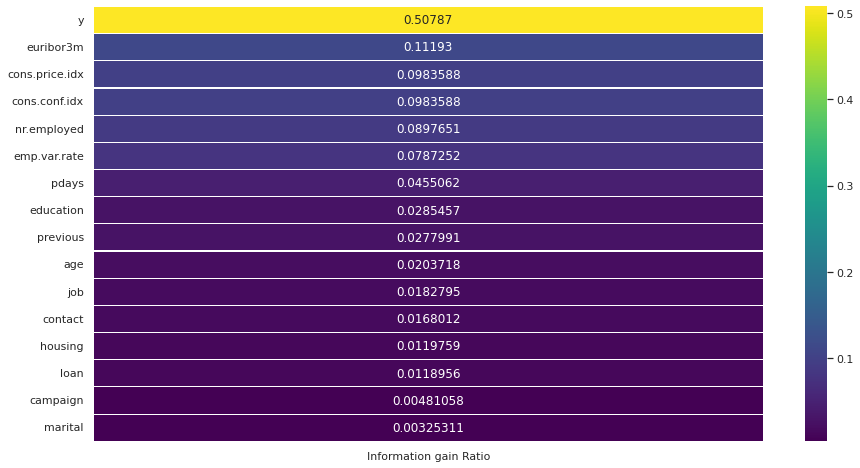

In [ ]:
for_infogain_function = for_infogain_function.drop(['month', 'poutcome', 'default',"day_of_week"], axis=1)
info_gain = highest_info_gain(for_infogain_function)
igr = pd.Series(info_gain).to_frame('Information gain Ratio')
igr = igr.sort_values(["Information gain Ratio"], ascending=False)
sns.set(rc = {'figure.figsize':(15,8)})

sns.heatmap(igr, annot=True, fmt="g", cmap='viridis', linewidths=.1)

## Here is all our scratch code. 
Everything that we tried and messed around with during the project is here (except for Caleb's graphs. Those are in a seperate file). It's really messy and there's limited comments, and don't take the labels seriously. We all worked on each section regardless of the name shown

#### Denver's Tests

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import scipy
import pandas.core
from scipy.stats import entropy

campaign = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank.csv')
campaign = campaign.replace('unknown', np.nan)
campaign = campaign.replace('nonexistent', np.nan)
campaign = campaign.replace('', np.nan)

# Un-comment out to see a visual representation of the original dataframe.
# campaign.head()

In [ ]:
campaign_missing = campaign.isna()

# campaign_missing.head()
campaign_num_missing = campaign_missing.sum().astype(np.float64)

campaign_num_missing = campaign_num_missing.div(41188).mul(100).round(2)
campaign_num_missing

age                0.00
job                0.80
marital            0.19
education          4.20
default           20.87
housing            2.40
loan               2.40
contact            0.00
month              0.00
day_of_week        0.00
campaign           0.00
pdays              0.00
previous           0.00
poutcome          86.34
emp.var.rate       0.00
cons.price.idx     0.00
cons.conf.idx      0.00
euribor3m          0.00
nr.employed        0.00
y                  0.00
dtype: float64

In [ ]:
def calc_entropy(column):
    """
    Calculate entropy given a pandas series, list, or numpy array.
    """
    from scipy.stats import entropy
    pd_series = pd.Series(column)
    counts = pd_series.value_counts()
    entropy = entropy(counts,base=2)
    return entropy
    
calc_entropy(campaign["marital"])

1.3064540578939539

In [ ]:
# s = pd.Series(campaign.age)
# counts = s.nunique()
# counts

In [ ]:
print("Entropy in bits\n")
for column in campaign:
    total_entropy = calc_entropy(campaign[column])
    print(f'{column}: %.3f bits' % total_entropy)

Entropy in bits

age: 5.295 bits
job: 2.936 bits
marital: 1.306 bits
education: 2.406 bits
default: 0.001 bits
housing: 0.996 bits
loan: 0.623 bits
contact: 0.947 bits
month: 2.649 bits
day_of_week: 2.321 bits
campaign: 2.422 bits
pdays: 0.346 bits
previous: 0.702 bits
poutcome: 0.802 bits
emp.var.rate: 2.338 bits
cons.price.idx: 3.440 bits
cons.conf.idx: 3.440 bits
euribor3m: 6.039 bits
nr.employed: 2.420 bits
y: 0.508 bits


In [ ]:
def calc_information_gain(data, split_name, target_name):
    """
    Calculate information gain given a data set, column to split on, and target
    """
    # Calculate the original entropy
    original_entropy = calc_entropy(campaign[target_name])
    
    #Find the unique values in the column
    values = campaign[split_name].unique()
    values_total = campaign[split_name].nunique()

    lists = []
    #append lists to add each column of unique data to each-other
    # Make as many subsets of the data as needed, based on the unique values
    for i in values:
      lists.append(data[data[split_name] == i])
    to_subtract = 0
    
    # This took me a while to figure out but this takes each split within a column that was created based off of each data type and it figures out the remaining entropy
    for subset in lists:
          prob = (subset.shape[0] / data.shape[0]) 
          to_subtract += prob * calc_entropy(subset[target_name])

    
    # Return information gain
    return (original_entropy - to_subtract)

In [ ]:
def calc_information_gain_ratio(data, split_name, target_name):
    """
    Calculate information gain given a data set, column to split on, and target
    """
    # Calculate the original entropy
    original_entropy = calc_entropy(campaign[target_name])
    feature_entropy = calc_entropy(campaign[split_name])
    #Find the unique values in the column
    values = campaign[split_name].unique()
    values_total = campaign[split_name].nunique()

    lists = []
    #append lists to add each column of unique data to each-other
    # Make as many subsets of the data as needed, based on the unique values
    for i in values:
      lists.append(data[data[split_name] == i])
    to_subtract = 0
    
    # This took me a while to figure out but this takes each split within a column that was created based off of each data type and it figures out the remaining entropy
    for subset in lists:
          prob = (subset.shape[0] / data.shape[0]) 
          to_subtract += prob * calc_entropy(subset[target_name])

    
    # Return information gain
    ig = original_entropy - to_subtract
    return (ig / feature_entropy)

In [ ]:
campaign["age"].unique()

array([56, 57, 37, 40, 45, 59, 41, 24, 25, 29, 35, 54, 46, 50, 39, 30, 55,
       49, 34, 52, 58, 32, 38, 44, 42, 60, 53, 47, 51, 48, 33, 31, 43, 36,
       28, 27, 26, 22, 23, 20, 21, 61, 19, 18, 70, 66, 76, 67, 73, 88, 95,
       77, 68, 75, 63, 80, 62, 65, 72, 82, 64, 71, 69, 78, 85, 79, 83, 81,
       74, 17, 87, 91, 86, 98, 94, 84, 92, 89])

In [ ]:
def highest_info_gain(columns):
  #Intialize an empty dictionary for information gains
  information_gains = {}
  
  #Iterate through each column name in our list
  for col in columns:
    #Find the information gain for the column
    information_gain = calc_information_gain(campaign, col, 'y')
    #Add the information gain to our dictionary using the column name as the ekey                                         
    information_gains[col] = information_gain
  
  #Return the key with the highest value                                          
  return (information_gains)

In [ ]:
def ratio_highest_info_gain(columns):
  #Intialize an empty dictionary for information gains
  information_gains = {}
  
  #Iterate through each column name in our list
  for col in columns:
    #Find the information gain for the column
    information_gain = calc_information_gain_ratio(campaign, col, 'y')
    #Add the information gain to our dictionary using the column name as the ekey                                         
    information_gains[col] = information_gain
  
  #Return the key with the highest value                                          
  return (information_gains)

In [ ]:
info_gain = highest_info_gain(campaign.columns)
marklist = sorted(info_gain.items(), key=lambda x:x[1], reverse=True)
sortdict = dict(marklist)
print("Information Gain\n")
for key in sortdict:
    print(key, ' : ', info_gain[key].round(3))

Information Gain

y  :  0.508
poutcome  :  0.416
euribor3m  :  0.112
cons.price.idx  :  0.098
cons.conf.idx  :  0.098
nr.employed  :  0.09
emp.var.rate  :  0.079
default  :  0.069
pdays  :  0.046
month  :  0.038
education  :  0.029
previous  :  0.028
age  :  0.02
job  :  0.018
contact  :  0.017
housing  :  0.012
loan  :  0.012
campaign  :  0.005
marital  :  0.003
day_of_week  :  0.0


In [ ]:
info_gain_ratio = ratio_highest_info_gain(campaign)
marklist = sorted(info_gain_ratio.items(), key=lambda x:x[1], reverse=True)
sortdict = dict(marklist)
print("Information Gain Ratio\n")
for key in sortdict:
    print(key, ' : ', info_gain_ratio[key].round(6))

Information Gain Ratio

default  :  50.813123
y  :  1.0
poutcome  :  0.518648
pdays  :  0.13136
previous  :  0.039581
nr.employed  :  0.037095
emp.var.rate  :  0.033677
cons.price.idx  :  0.028589
cons.conf.idx  :  0.028589
loan  :  0.019086
euribor3m  :  0.018536
contact  :  0.017742
month  :  0.014382
housing  :  0.012023
education  :  0.011863
job  :  0.006226
age  :  0.003847
marital  :  0.00249
campaign  :  0.001986
day_of_week  :  0.0002


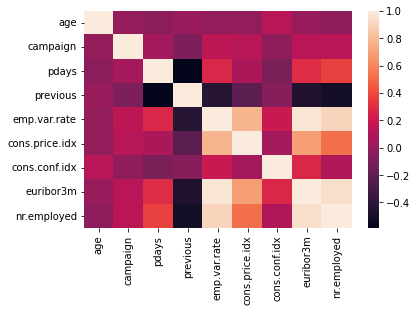

In [ ]:
corr = campaign.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)


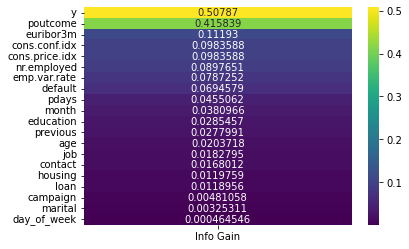

In [ ]:
igr = pd.Series(info_gain_ratio).to_frame('Information gain Ratio')
ig = pd.Series(info_gain).to_frame('Info Gain')
igr = igr.sort_values(["Information gain Ratio"], ascending=False)
ig = ig.sort_values(["Info Gain"], ascending=False)
igr.head()


sns.heatmap(ig, annot=True, fmt="g", cmap='viridis')


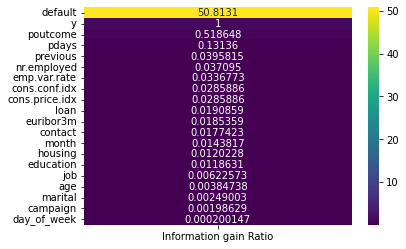

In [ ]:
sns.heatmap(igr, annot=True, fmt="g", cmap='viridis')

#### Ben's Section

In [ ]:
import pandas as pd

camp = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank.csv')

camp

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [ ]:
camp['housing'] = camp['housing'].map({'yes':1,'no':0,'unknown':0})
camp['loan'] = camp['loan'].map({'yes':1,'no':0,'unknown':0})
camp['default'] = camp['default'].map({'yes':1,'no':0,'unknown':0})
camp['poutcome'] = camp['poutcome'].map({'nonexistent':0,'failure':1,'success':2})
camp['y'] = camp['y'].map({'yes':1,'no':0})


In [ ]:
camp = camp.drop('poutcome', 1)
camp = camp.drop('default', 1)
# info_gain_ratio = ratio_highest_info_gain(camp)
# igr = pd.Series(info_gain_ratio).to_frame('Information gain Ratio')
# igr = igr.sort_values(["Information gain Ratio"], ascending=False)
# sns.heatmap(igr, annot=True, fmt="g", cmap='viridis')

For some reason my functions for information gains dont work with the get_dummies function

So I moved it so we can see info gains

In [ ]:
# camp = pd.get_dummies(data=camp, columns=['job','day_of_week', 'education','contact','marital'],dtype=int)
camp = camp.drop(['month'], axis=1)
camp = pd.get_dummies(data=camp, columns=['job','day_of_week', 'education','contact','marital'],dtype=int)
camp.head()

,age,housing,loan,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,contact_cellular,contact_telephone,marital_divorced,marital_married,marital_single,marital_unknown
0,56,0,0,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
1,57,0,0,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
2,37,1,0,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
3,40,0,0,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
4,56,0,1,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0


In [ ]:
camp['age'] = pd.cut(camp['age'], bins=4, labels=['1', '2', '3', '4']) # 1 = '16.919-37.25', 2 = '37.25-57.5', 3 = '57.5-77.75', 4 = '77.75-98.0'
camp["age"].unique()



['2', '1', '3', '4']
Categories (4, object): ['1' < '2' < '3' < '4']

In [ ]:
df_mean = camp["nr.employed"].mean()
print(df_mean)

5167.035910941844


In [ ]:
# camp['nr.employed'] = pd.qcut(camp['nr.employed'], q=2,  labels=['1', '2']) #[(4963.599, 5191.0] < (5191.0, 5228.1]]
# camp["nr.employed"].unique()
camp['nr.employed'] = pd.cut(camp['nr.employed'], bins=6, labels=['4986', '5030', '5074', '5118', '5162', '5206']) # 1 = '16.919-37.25', 2 = '37.25-57.5', 3 = '57.5-77.75', 4 = '77.75-98.0'
camp["nr.employed"].unique()

['5206', '5162', '5118', '5074', '5030', '4986']
Categories (6, object): ['4986' < '5030' < '5074' < '5118' < '5162' < '5206']

In [ ]:
camp

,age,housing,loan,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,contact_cellular,contact_telephone,marital_divorced,marital_married,marital_single,marital_unknown
0,2,0,0,1,999,0,1.1,93.994,-36.4,4.857,5206,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
1,2,0,0,1,999,0,1.1,93.994,-36.4,4.857,5206,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
2,1,1,0,1,999,0,1.1,93.994,-36.4,4.857,5206,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
3,2,0,0,1,999,0,1.1,93.994,-36.4,4.857,5206,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
4,2,0,1,1,999,0,1.1,93.994,-36.4,4.857,5206,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,3,1,0,1,999,0,-1.1,94.767,-50.8,1.028,4986,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
41184,2,0,0,1,999,0,-1.1,94.767,-50.8,1.028,4986,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
41185,2,1,0,2,999,0,-1.1,94.767,-50.8,1.028,4986,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0
41186,2,0,0,1,999,0,-1.1,94.767,-50.8,1.028,4986,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0


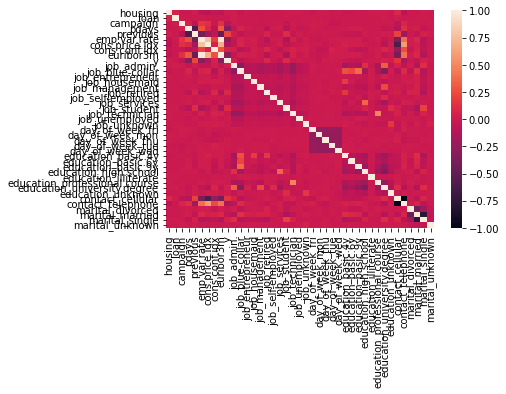

In [ ]:
corr = camp.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

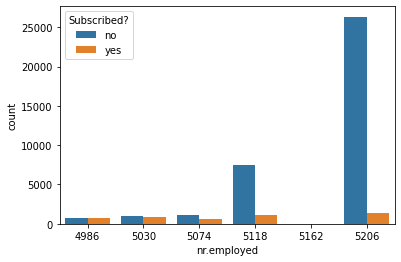

In [ ]:
import seaborn as sns
plt = sns.countplot(data = camp, x = camp["nr.employed"], hue = "y")
plt.legend(title='Subscribed?', loc='upper left', labels=['no', 'yes'])

In [ ]:
# Jacob - This line of code wasn't working due to "ValueError: Could not interpret input 'default'"
# I commented out so that I could use run all
# sns.countplot(data = camp, x = "default", hue = "y")

In [ ]:
# Jacob - This line of code wasn't working due to "ValueError: Could not interpret input 'poutcome'"
# I commented out so that I could use run all
# sns.countplot(data = camp, x = "poutcome")

In [ ]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import plot_confusion_matrix
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
# define dataset
X = camp.loc[:, camp.columns != 'y'] # Features
y = camp.y # Target
# summarize class distribution
print(Counter(y))
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)
# X_over, y_over = undersample.fit_resample(X, y)
# summarize class distribution
print(Counter(y_over))

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Counter({0: 36548, 1: 4640})
Counter({0: 36548, 1: 36548})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2)

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth = 35)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [ ]:
import pickle
# save the model to disk
filename = 'bank_model.sav'
pickle.dump(clf, open(filename, 'wb')) 

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
y_pred = loaded_model.predict(X_test)

Accuracy: 0.9341313269493844
Recall:  0.9895661724327293


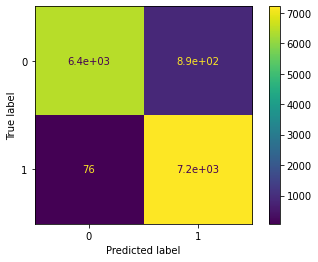

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# We want recall
print("Recall: ", metrics.recall_score(y_test, y_pred))
# Precision Matix
plot_confusion_matrix(clf, X_test, y_test)

In [ ]:
x = len(camp.query("y == 1"))
x
y = len(camp.query("y == 0"))
y

print(x, y, x/(x+y))

4640 36548 0.11265417111780131


In [ ]:
from sklearn import tree
from sklearn.metrics import classification_report
import altair as alt
#tree.plot_tree(clf, feature_names=X.columns, filled=True)
pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(classification_report(y_test, y_pred))

#print(tree.export_text(clf))

# 

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      7336
           1       0.89      0.99      0.94      7284

    accuracy                           0.93     14620
   macro avg       0.94      0.93      0.93     14620
weighted avg       0.94      0.93      0.93     14620



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9299589603283174

In [ ]:
feature_df = pd.DataFrame({'features':X.columns, 'importance':clf.feature_importances_})

alt.Chart(feature_df).mark_bar().encode(
    x = 'importance',
     y = alt.Y('features', sort='-x')
 )

alt.Chart(...)

Accuracy: 0.8954438779639071
Recall:  0.210943124550036


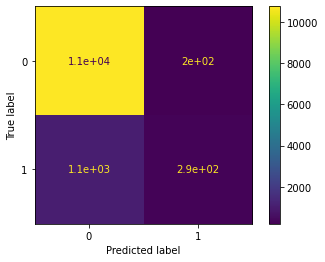

In [ ]:
camp2 = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bank.csv')
camp2['y'] = camp2['y'].map({'yes':1,'no':0})
# camp2.head()
X = camp2[['emp.var.rate', 'cons.price.idx', 'cons.conf.idx','euribor3m','nr.employed']] # Features
y = camp2.y # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
# We want recall
print("Recall: ", metrics.recall_score(y_test, y_pred))
# Precision Matix
plot_confusion_matrix(clf, X_test, y_test)

In [ ]:
camp2.corr()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.000000,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.030399
campaign,0.004594,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,-0.066357
pdays,-0.034369,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605,-0.324914
previous,0.024365,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.230181
emp.var.rate,-0.000371,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,-0.298334
cons.price.idx,0.000857,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.136211
cons.conf.idx,0.129372,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,0.054878
euribor3m,0.010767,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154,-0.307771
nr.employed,-0.017725,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,-0.354678
y,0.030399,-0.066357,-0.324914,0.230181,-0.298334,-0.136211,0.054878,-0.307771,-0.354678,1.000000


In [ ]:
from imblearn.over_sampling import RandomOverSampler
# https://imbalanced-learn.readthedocs.io/en/stable/user_guide.html


# Let's over sample the minority class, which samples with replacement until the
# majority (died) and the minority (survived) are equal
ro = RandomOverSampler()

# Decide which features to use

X = camp2[['emp.var.rate', 'cons.price.idx', 'cons.conf.idx','euribor3m','nr.employed']]
y = camp2.y

# Oversample, note that we oversample X and y at the same time in order to 
# make sure our features and targets stay synched.
X_new, y_new = ro.fit_resample(X, y)

# Convert this to a dataframe and check the counts, now they're equal, because
# we have a bunch of duplicate survivors
survivors = pd.DataFrame(y_new)
survivors.value_counts()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1    36548
0    36548
dtype: int64